In [13]:
from positions import *
from ultralytics import YOLO
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

pieces_model_weights = 'best_detection.pt'
board_model_weights = 'best_segmentation.pt'

TEST_FOLDER_IMAGES = 'dataset/test/images'
TEST_FOLDER_LABELS = 'dataset/test/correct_output'

image = 'dataset/test/images/0000.png'
white_turn = False

pieces_model = YOLO(pieces_model_weights)
board_model = YOLO(board_model_weights)

images = [os.path.join(TEST_FOLDER_IMAGES, f) for f in os.listdir(TEST_FOLDER_IMAGES) if f.endswith('.png')]

classes = {
    'B': 0, 'K': 1, 'N': 2, 'P': 3, 'Q': 4, 'R': 5,
    'b': 6, 'k': 7, 'n': 8, 'p': 9, 'q': 10, 'r': 11
}
inv_classes = {v: k for k, v in classes.items()}


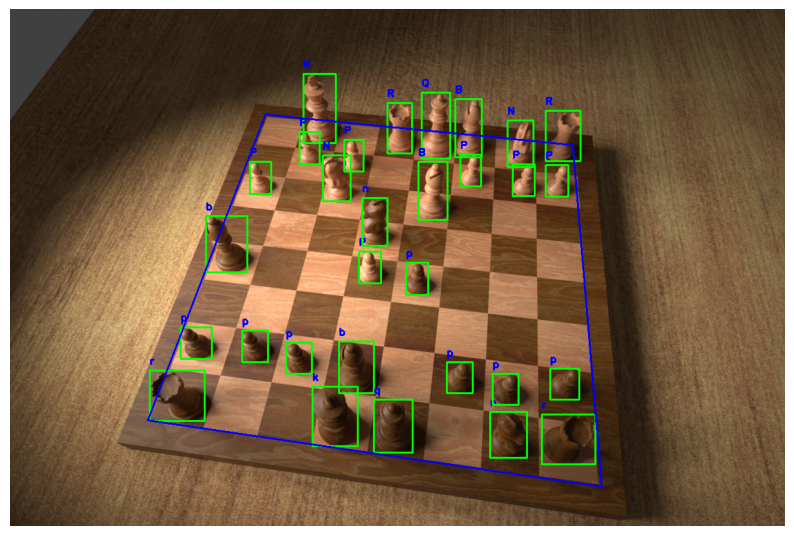

Predicted FEN: rn1qk2r/ppp1bppp/8/3pP2b/4n3/3B1N1P/PPP2PP1/RNBQR1K1


In [ ]:
# Detect pieces
pieces_results = pieces_model.predict(image, conf=0.5, verbose=False, save=False)

# Detect board
board_results = board_model.predict(image, conf=0.5, verbose=False, save=False)

detected_pieces = []

# Process results
if board_results[0].masks.xy is not None and len(board_results[0].masks.xy) > 0:
    # Get the original mask contours from xy coordinates
    mask_contours = board_results[0].masks.xy[0]
    
    # Convert to numpy array for OpenCV operations
    contour_points = np.array(mask_contours, dtype=np.float32)
    
    # Approximate the contour to a quadrilateral using masks.xy
    epsilon = 0.05 * cv2.arcLength(contour_points, True)
    board_vert = cv2.approxPolyDP(contour_points, epsilon, True)
    rep = 0
    while len(board_vert) != 4:
        if len(board_vert) > 4:
            epsilon *= 1.05
        else:
            epsilon *= 0.95
        board_vert = cv2.approxPolyDP(contour_points, epsilon, True)
        rep += 1

        if rep > 100:
            print('Too many iterations, breaking out')
            break
    if len(board_vert) == 4:
        board_vert = board_vert.reshape(-1, 2)  # Flatten to 2D array
        board_vert = [[float(x), float(y)] for x, y in board_vert]


        transform = calc_transform(board_vert)
    
        # Process pieces results
        if len(pieces_results) > 0:
            for j in range(len(pieces_results[0].boxes.cls)):
                box = [float(pieces_results[0].boxes.xyxy[j][0]), float(pieces_results[0].boxes.xyxy[j][1]),
                    float(pieces_results[0].boxes.xywh[j][2]), float(pieces_results[0].boxes.xywh[j][3])]
                
                piece = {
                    'piece' : inv_classes[int(pieces_results[0].boxes.cls[j])],
                    'box' : box,
                    'square' : calc_position(box, transform, 0 if white_turn else 2)
                }
                
                if not 'ERROR' in piece['square']:
                    detected_pieces.append(piece)
    
    # Convert detected pieces to FEN
    fen_pred = pieces_to_fen(detected_pieces)


    # Plot the bounding box and detected pieces
    if len(detected_pieces) > 0:
        img = cv2.imread(image)
        for piece in detected_pieces:
            box = piece['box']
            cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3])), (0, 255, 0), 2)
            cv2.putText(img, piece['piece'], (int(box[0]), int(box[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Draw the board contour
        #if len(board_vert) == 4:
        #    cv2.polylines(img, [np.array(board_vert, dtype=np.int32)], isClosed=True, color=(255, 0, 0), thickness=2)

        # Display the image with detected pieces
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        print("No pieces detected in the image.")
    # Print the predicted FEN
    print("Predicted FEN:", fen_pred)
else:
    print("No board detected in the image.")